# Variational autoencoders for collaborative filtering 

This notebook accompanies the paper "*Variational autoencoders for collaborative filtering*" by Dawen Liang, Rahul G. Krishnan, Matthew D. Hoffman, and Tony Jebara, in The Web Conference (aka WWW) 2018.

In this notebook, we will show a complete self-contained example of training a variational autoencoder (as well as a denoising autoencoder) with multinomial likelihood (described in the paper) on the public Movielens-20M dataset, including both data preprocessing and model training.

In [0]:
!pip install bottleneck

    100% |████████████████████████████████| 112kB 4.6MB/s 
  Running setup.py bdist_wheel for bottleneck ... - \ | / - \ | / done
  Stored in directory: /root/.cache/pip/wheels/f2/bf/ec/e0f39aa27001525ad455139ee57ec7d0776fe074dfd78c97e4
Successfully built bottleneck


In [0]:
import os
import shutil
import sys

import numpy as np
from scipy import sparse

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sn
sn.set()

import pandas as pd

import tensorflow as tf
from tensorflow.contrib.layers import apply_regularization, l2_regularizer,l1_regularizer

import bottleneck as bn

import seaborn as sns

## Data preprocessing

We load the data and create train/validation/test splits following strong generalization: 

- We split all users into training/validation/test sets. 

- We train models using the entire click history of the training users. 

- To evaluate, we take part of the click history from held-out (validation and test) users to learn the necessary user-level representations for the model and then compute metrics by looking at how well the model ranks the rest of the unseen click history from the held-out users.

First, download the dataset at http://files.grouplens.org/datasets/movielens/ml-20m.zip

In [0]:
!wget http://files.grouplens.org/datasets/movielens/ml-20m.zip

--2018-12-16 20:38:36--  http://files.grouplens.org/datasets/movielens/ml-20m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.34.235
Connecting to files.grouplens.org (files.grouplens.org)|128.101.34.235|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 198702078 (189M) [application/zip]
Saving to: ‘ml-20m.zip’

ml-20m.zip          100%[===================>] 189.50M  56.0MB/s    in 3.7s    

2018-12-16 20:38:40 (51.1 MB/s) - ‘ml-20m.zip’ saved [198702078/198702078]



In [0]:
!unzip ml-20m.zip

Archive:  ml-20m.zip
   creating: ml-20m/
  inflating: ml-20m/genome-scores.csv  
  inflating: ml-20m/genome-tags.csv  
  inflating: ml-20m/links.csv        
  inflating: ml-20m/movies.csv       
  inflating: ml-20m/ratings.csv      
  inflating: ml-20m/README.txt       
  inflating: ml-20m/tags.csv         


In [0]:
### change `DATA_DIR` to the location where movielens-20m dataset sits
DATA_DIR = 'ml-20m/'

In [0]:
raw_data = pd.read_csv(os.path.join(DATA_DIR, 'ratings.csv'), header=0)

* Filtering data to obtain only those movies with at least one rate hight than 3.5

In [0]:
# binarize the data (only keep ratings >= 4)
raw_data = raw_data[raw_data['rating'] > 3.5]

### Data splitting procedure

- Select 10K users as heldout users, 10K users as validation users, and the rest of the users for training
- Use all the items from the training users as item set
- For each of both validation and test user, subsample 80% as fold-in data and the rest for prediction 

In [0]:
def get_count(tp, id):
    return tp[id].value_counts()

In [0]:
def filter_triplets(tp, min_uc=5, min_sc=0):
    # Only keep the triplets for items which were clicked on by at least min_sc users. 
    if min_sc > 0:
        itemcount = get_count(tp, 'movieId')
        tp = tp[tp['movieId'].isin(itemcount.index[itemcount >= min_sc])]
    
    # Only keep the triplets for users who clicked on at least min_uc items
    # After doing this, some of the items will have less than min_uc users, but should only be a small proportion
    if min_uc > 0:
        usercount = get_count(tp, 'userId')
        tp = tp[tp['userId'].isin(usercount.index[usercount >= min_uc])]
    
    # Update both usercount and itemcount after filtering
    usercount, itemcount = get_count(tp, 'userId'), get_count(tp, 'movieId') 
    return tp, usercount, itemcount

* We only keep users who have strong rate(>3.5) for at least five movies. 


* Question: user filter first or movie filter first?

In [0]:
raw_data, user_activity, item_popularity = filter_triplets(raw_data)

In [0]:
sparsity = 1. * raw_data.shape[0] / (user_activity.shape[0] * item_popularity.shape[0])

print("After filtering, there are %d watching events from %d users and %d movies (sparsity: %.3f%%)" % 
      (raw_data.shape[0], user_activity.shape[0], item_popularity.shape[0], sparsity * 100))

After filtering, there are 9990682 watching events from 136677 users and 20720 movies (sparsity: 0.353%)


In [0]:
#Randomize user id
unique_uid = user_activity.index

np.random.seed(98765)
idx_perm = np.random.permutation(unique_uid.size)
unique_uid = unique_uid[idx_perm]

In [0]:
# create train/validation/test users
n_users = unique_uid.size
n_heldout_users = 10000

tr_users = unique_uid[:(n_users - n_heldout_users * 2)]
vd_users = unique_uid[(n_users - n_heldout_users * 2): (n_users - n_heldout_users)]
te_users = unique_uid[(n_users - n_heldout_users):]
print(len(tr_users),len(vd_users),len(te_users))


116677 10000 10000


In [0]:
#get training set 
train_plays = raw_data.loc[raw_data['userId'].isin(tr_users)]

In [0]:
#get unique items for training set
unique_sid = pd.unique(train_plays['movieId'])

In [0]:
show2id = dict((sid, i) for (i, sid) in enumerate(unique_sid))
profile2id = dict((pid, i) for (i, pid) in enumerate(unique_uid))

In [0]:
pro_dir = os.path.join(DATA_DIR, 'pro_sg')

if not os.path.exists(pro_dir):
    os.makedirs(pro_dir)

with open(os.path.join(pro_dir, 'unique_sid.txt'), 'w') as f:
    for sid in unique_sid:
        f.write('%s\n' % sid)

In [0]:
def split_train_test_proportion(data, test_prop=0.2):
    data_grouped_by_user = data.groupby('userId')
    tr_list, te_list = list(), list()

    np.random.seed(98765)

    for i, (_, group) in enumerate(data_grouped_by_user):
        n_items_u = len(group)
        group = group.sort_values(['timestamp'],ascending=True)
        if n_items_u >= 5:
            idx = np.zeros(n_items_u, dtype='bool')
            idx[np.random.choice(n_items_u, size=int(test_prop * n_items_u), replace=False).astype('int64')] = True
            '''
            use only last test_prop item to be testing points
            '''
            #idx[-int(test_prop*n_items_u):]=True
            
            tr_list.append(group[np.logical_not(idx)])
            te_list.append(group[idx])
        

        if i % 1000 == 0:
            print("%d users sampled" % i)
            sys.stdout.flush()

    data_tr = pd.concat(tr_list)
    data_te = pd.concat(te_list)
    
    return data_tr, data_te

In [0]:
#filter validat data to have item only in unique training data set
vad_plays = raw_data.loc[raw_data['userId'].isin(vd_users)]
vad_plays = vad_plays.loc[vad_plays['movieId'].isin(unique_sid)]

In [0]:
vad_plays_tr, vad_plays_te = split_train_test_proportion(vad_plays)

0 users sampled
1000 users sampled
2000 users sampled
3000 users sampled
4000 users sampled
5000 users sampled
6000 users sampled
7000 users sampled
8000 users sampled
9000 users sampled


In [0]:
#filter testing data to have item only in unique training data set
test_plays = raw_data.loc[raw_data['userId'].isin(te_users)]
test_plays = test_plays.loc[test_plays['movieId'].isin(unique_sid)]

In [0]:
test_plays_tr, test_plays_te = split_train_test_proportion(test_plays)

0 users sampled
1000 users sampled
2000 users sampled
3000 users sampled
4000 users sampled
5000 users sampled
6000 users sampled
7000 users sampled
8000 users sampled
9000 users sampled


### Save the data into (user_index, item_index) format

In [0]:
def numerize(tp):
    uid = list(map(lambda x: profile2id[x], tp['userId']))
    sid = list(map(lambda x: show2id[x], tp['movieId']))
    return pd.DataFrame(data={'uid': uid, 'sid': sid}, columns=['uid', 'sid'])

In [0]:
train_data = numerize(train_plays)
train_data.to_csv(os.path.join(pro_dir, 'train.csv'), index=False)

In [0]:
vad_data_tr = numerize(vad_plays_tr)
vad_data_tr.to_csv(os.path.join(pro_dir, 'validation_tr.csv'), index=False)

In [0]:
vad_data_te = numerize(vad_plays_te)
vad_data_te.to_csv(os.path.join(pro_dir, 'validation_te.csv'), index=False)

In [0]:
test_data_tr = numerize(test_plays_tr)
test_data_tr.to_csv(os.path.join(pro_dir, 'test_tr.csv'), index=False)

In [0]:
test_data_te = numerize(test_plays_te)
test_data_te.to_csv(os.path.join(pro_dir, 'test_te.csv'), index=False)

## Model definition and training

We define two related models: denoising autoencoder with multinomial likelihood (Multi-DAE in the paper) and partially-regularized variational autoencoder with multinomial likelihood (Multi-VAE^{PR} in the paper).

### Model definition

__Notations__: We use $u \in \{1,\dots,U\}$ to index users and $i \in \{1,\dots,I\}$ to index items. In this work, we consider learning with implicit feedback. The user-by-item interaction matrix is the click matrix $\mathbf{X} \in \mathbb{N}^{U\times I}$. The lower case $\mathbf{x}_u =[X_{u1},\dots,X_{uI}]^\top \in \mathbb{N}^I$ is a bag-of-words vector with the number of clicks for each item from user u. We binarize the click matrix. It is straightforward to extend it to general count data.

The objective of Multi-VAE^{PR} (evidence lower-bound, or ELBO) for a single user $u$ is:
$$
\mathcal{L}_u(\theta, \phi) = \mathbb{E}_{q_\phi(z_u | x_u)}[\log p_\theta(x_u | z_u)] - \beta \cdot KL(q_\phi(z_u | x_u) \| p(z_u))
$$
where $q_\phi$ is the approximating variational distribution (inference model). $\beta$ is the additional annealing parameter that we control. The objective of the entire dataset is the average over all the users. It can be trained almost the same as Multi-DAE, thanks to reparametrization trick. 

In [0]:
class MultiVAE(object):
    '''
    p_dim: dimensions for each layer in encoders(input, layer 1,..., ouput)
    q_dim: dimensions for decoders(input, layer 1,..., output)
    lam: regularization term for KL Divergence
    lr: Learning rate
    '''
    
    
    
    def __init__(self, p_dims, q_dims=None, lam=0.01, lr=1e-3, random_seed=None):
        self.p_dims = p_dims
        if q_dims is None:
            #q_dims=inverse of p_dims
            self.q_dims = p_dims[::-1]
        else:
            assert q_dims[0] == p_dims[-1], "Input and output dimension must equal each other for autoencoders."
            assert q_dims[-1] == p_dims[0], "Latent dimension for p- and q-network mismatches."
            self.q_dims = q_dims
        self.dims = self.q_dims + self.p_dims[1:]
        
        self.lam = lam
        self.lr = lr
        self.random_seed = random_seed

        self.construct_placeholders()
    
    
    def construct_placeholders(self):
        self.input_ph = tf.placeholder(
            dtype=tf.float32, shape=[None, self.dims[0]],name='Input_variable')
        #dropout probability
        self.keep_prob_ph = tf.placeholder_with_default(1.0, shape=None,name='dropoff_probability')

        # placeholders with default values when scoring
        self.is_training_ph = tf.placeholder_with_default(0., shape=None, name='Unknown')
        self.anneal_ph = tf.placeholder_with_default(1., shape=None, name='Anneal_KL')
        
    def build_graph(self):
        # Initialize paramaters values
        self._construct_weights()
        
        saver, logits, KL, sampled_z = self.forward_pass()
        #Softmax loss
        '''
        log_softmax_var = tf.nn.log_softmax(logits)
        neg_ll = -tf.reduce_mean(tf.reduce_sum(
            log_softmax_var * self.input_ph,
            axis=-1))
        '''
        
        #one vs each loss
        
        res=[]
        for i in range(self.p_dims[-1]):
          resI=tf.constant(0.)
          for j in range(self.p_dims[-1]):
            if i!=j:
              print('check',i,j,p_dims[-1])
              resI=tf.add(resI,tf.log(tf.add(tf.constant(1.),tf.exp(logits[:,j]-logits[:,i]))))
          res.append(resI)
        log_ove=tf.concat(res,axis=-1)
        
        neg_ll = -tf.reduce_mean(tf.reduce_sum(
            log_ove * self.input_ph,
            axis=-1))
        
        
        # apply regularization to weights
        reg = l2_regularizer(self.lam)
        #reg = l1_regularizer(self.lam)
        reg_var = apply_regularization(reg, self.weights_q + self.weights_p)
        #reg_var = apply_regularization(reg, self.weights_q)
        
        
        # tensorflow l2 regularization multiply 0.5 to the l2 norm
        # multiply 2 so that it is back in the same scale
        
        # two constrain: 1. anneal term for KL
        #                2. L2 norm for all params in encoder and decoder network(reg_var)
        neg_ELBO = neg_ll + self.anneal_ph * KL + 2 * reg_var
        
        train_op = tf.train.AdamOptimizer(self.lr).minimize(neg_ELBO)

        # add summary statistics
        tf.summary.scalar('negative_multi_ll', neg_ll)
        tf.summary.scalar('KL', KL)
        tf.summary.scalar('neg_ELBO_train', neg_ELBO)
        merged = tf.summary.merge_all()
        
        return saver, logits, neg_ELBO, train_op, merged, sampled_z
    
    def q_graph(self):
        '''
        encoder network
        '''
        mu_q, std_q, KL = None, None, None
        
        h = tf.nn.l2_normalize(self.input_ph, 1)
        h = tf.nn.dropout(h, self.keep_prob_ph)
        
        for i, (w, b) in enumerate(zip(self.weights_q, self.biases_q)):
            h = tf.matmul(h, w) + b
            
            if i != len(self.weights_q) - 1:
                # tanh activation function
                h = tf.nn.tanh(h)
            else:
                mu_q = h[:, :self.q_dims[-1]]
                logvar_q = h[:, self.q_dims[-1]:]

                std_q = tf.exp(0.5 * logvar_q)
                KL = tf.reduce_mean(tf.reduce_sum(0.5 * (-logvar_q + tf.exp(logvar_q) + mu_q**2 - 1), axis=1))
        return mu_q, std_q, KL

    def p_graph(self, z):
        h = z
        
        for i, (w, b) in enumerate(zip(self.weights_p, self.biases_p)):
            h = tf.matmul(h, w) + b
            
            if i != len(self.weights_p) - 1:
                h = tf.nn.tanh(h)
        return h

    def forward_pass(self):
        '''
        Compute each parts of loss function: logits and KL Divergence
        '''
      
        # encoder output
        mu_q, std_q, KL = self.q_graph()
       
        # reparametrization trick 
        epsilon = tf.random_normal(tf.shape(std_q))
        sampled_z = mu_q + self.is_training_ph * epsilon * std_q

        # p-network
        logits = self.p_graph(sampled_z)
        
        return tf.train.Saver(), logits, KL, sampled_z

    def _construct_weights(self):
        self.weights_q, self.biases_q = [], []
        
        for i, (d_in, d_out) in enumerate(zip(self.q_dims[:-1], self.q_dims[1:])):
            if i == len(self.q_dims[:-1]) - 1:
                # last layer
                # we need two sets of parameters for mean and variance respectively
                d_out *= 2
            weight_key = "weight_q_{}to{}".format(i, i+1)
            bias_key = "bias_q_{}".format(i+1)
            
            self.weights_q.append(tf.get_variable(
                name=weight_key, shape=[d_in, d_out],
                # Xavier initializer method - uniform for weights params
                # One thing to be optimized
                initializer=tf.contrib.layers.xavier_initializer(seed=self.random_seed)
                #initializer = tf.initializers.he_normal(seed=self.random_seed)
            ))
            
            self.biases_q.append(tf.get_variable(
                name=bias_key, shape=[d_out],
                # Truncated Normal distribution for biases params
                initializer=tf.truncated_normal_initializer(
                    stddev=0.001, seed=self.random_seed)))
            
            # add summary stats
            tf.summary.histogram(weight_key, self.weights_q[-1])
            tf.summary.histogram(bias_key, self.biases_q[-1])
            
        self.weights_p, self.biases_p = [], []

        for i, (d_in, d_out) in enumerate(zip(self.p_dims[:-1], self.p_dims[1:])):
            weight_key = "weight_p_{}to{}".format(i, i+1)
            bias_key = "bias_p_{}".format(i+1)
            self.weights_p.append(tf.get_variable(
                name=weight_key, shape=[d_in, d_out],
                initializer=tf.contrib.layers.xavier_initializer(seed=self.random_seed)
                #initializer = tf.initializers.he_normal(seed=self.random_seed)
            ))
            
            self.biases_p.append(tf.get_variable(
                name=bias_key, shape=[d_out],
                initializer=tf.truncated_normal_initializer(
                    stddev=0.001, seed=self.random_seed)))
            
            # add summary stats
            tf.summary.histogram(weight_key, self.weights_p[-1])
            tf.summary.histogram(bias_key, self.biases_p[-1])

### Training/validation data, hyperparameters

Load the pre-processed training and validation data

In [0]:
unique_sid = list()
with open(os.path.join(pro_dir, 'unique_sid.txt'), 'r') as f:
    for line in f:
        unique_sid.append(line.strip())

n_items = len(unique_sid)

In [0]:
def load_train_data(csv_file):
    tp = pd.read_csv(csv_file)
    n_users = tp['uid'].max() + 1

    rows, cols = tp['uid'], tp['sid']
    data = sparse.csr_matrix((np.ones_like(rows),
                             (rows, cols)), dtype='float64',
                             shape=(n_users, n_items))
    return data

In [0]:
train_data = load_train_data(os.path.join(pro_dir, 'train.csv'))

In [0]:
def load_tr_te_data(csv_file_tr, csv_file_te):
    tp_tr = pd.read_csv(csv_file_tr)
    tp_te = pd.read_csv(csv_file_te)

    start_idx = min(tp_tr['uid'].min(), tp_te['uid'].min())
    end_idx = max(tp_tr['uid'].max(), tp_te['uid'].max())

    rows_tr, cols_tr = tp_tr['uid'] - start_idx, tp_tr['sid']
    rows_te, cols_te = tp_te['uid'] - start_idx, tp_te['sid']

    data_tr = sparse.csr_matrix((np.ones_like(rows_tr),
                             (rows_tr, cols_tr)), dtype='float64', shape=(end_idx - start_idx + 1, n_items))
    data_te = sparse.csr_matrix((np.ones_like(rows_te),
                             (rows_te, cols_te)), dtype='float64', shape=(end_idx - start_idx + 1, n_items))
    return data_tr, data_te

In [0]:
vad_data_tr, vad_data_te = load_tr_te_data(os.path.join(pro_dir, 'validation_tr.csv'),
                                           os.path.join(pro_dir, 'validation_te.csv'))

Set up training hyperparameters

In [0]:
N = train_data.shape[0]
idxlist = np.arange(N)

# training batch size
batch_size = 500
batches_per_epoch = int(np.ceil(float(N) / batch_size))
print(batches_per_epoch)

N_vad = vad_data_tr.shape[0]
idxlist_vad = np.arange(N_vad)

# validation batch size (since the entire validation set might not fit into GPU memory)
batch_size_vad = 2000

# the total number of gradient updates for annealing
total_anneal_steps = 20000
# largest annealing parameter
anneal_cap = 2

234


Evaluate function: Normalized discounted cumulative gain (NDCG@k) and Recall@k

In [0]:
def NDCG_binary_at_k_batch(X_pred, heldout_batch, k=100):
    '''
    normalized discounted cumulative gain@k for binary relevance
    ASSUMPTIONS: all the 0's in heldout_data indicate 0 relevance
    '''
    batch_users = X_pred.shape[0]
    idx_topk_part = bn.argpartition(-X_pred, k, axis=1)
    topk_part = X_pred[np.arange(batch_users)[:, np.newaxis],
                       idx_topk_part[:, :k]]
    idx_part = np.argsort(-topk_part, axis=1)
    # X_pred[np.arange(batch_users)[:, np.newaxis], idx_topk] is the sorted
    # topk predicted score
    idx_topk = idx_topk_part[np.arange(batch_users)[:, np.newaxis], idx_part]
    # build the discount template
    tp = 1. / np.log2(np.arange(2, k + 2))

    DCG = (heldout_batch[np.arange(batch_users)[:, np.newaxis],
                         idx_topk].toarray() * tp).sum(axis=1)
    IDCG = np.array([(tp[:min(n, k)]).sum()
                     for n in heldout_batch.getnnz(axis=1)])
    return DCG / IDCG

In [0]:
def Recall_at_k_batch(X_pred, heldout_batch, k=100):
    batch_users = X_pred.shape[0]

    idx = bn.argpartition(-X_pred, k, axis=1)
    X_pred_binary = np.zeros_like(X_pred, dtype=bool)
    X_pred_binary[np.arange(batch_users)[:, np.newaxis], idx[:, :k]] = True

    X_true_binary = (heldout_batch > 0).toarray()
    tmp = (np.logical_and(X_true_binary, X_pred_binary).sum(axis=1)).astype(
        np.float32)
    recall = tmp / np.minimum(k, X_true_binary.sum(axis=1))
    return recall

### Train a Multi-VAE^{PR}

####Set Model

For ML-20M dataset, we set both the generative function $f_\theta(\cdot)$ and the inference model $g_\phi(\cdot)$ to be 3-layer multilayer perceptron (MLP) with symmetrical architecture. 

The generative function is a [200 -> 600 -> n_items] MLP, which means the inference function is a [n_items -> 600 -> 200] MLP. Thus the overall architecture for the Multi-VAE^{PR} is [n_items -> 600 -> 200 -> 600 -> n_items].

In [0]:
p_dims = [200, 600, n_items]

In [0]:

tf.reset_default_graph()
vae = MultiVAE(p_dims, lam=0.0, random_seed=98765)

saver, logits_var, loss_var, train_op_var, merged_var, sampled_z = vae.build_graph()
'''
ndcg_var = tf.Variable(0.0)
ndcg_dist_var = tf.placeholder(dtype=tf.float64, shape=None)
ndcg_summary = tf.summary.scalar('ndcg_at_k_validation', ndcg_var)
ndcg_dist_summary = tf.summary.histogram('ndcg_at_k_hist_validation', ndcg_dist_var)
merged_valid = tf.summary.merge([ndcg_summary, ndcg_dist_summary])
'''

check 0 1 20151
check 0 2 20151
check 0 3 20151
check 0 4 20151
check 0 5 20151
check 0 6 20151
check 0 7 20151
check 0 8 20151
check 0 9 20151
check 0 10 20151
check 0 11 20151
check 0 12 20151
check 0 13 20151
check 0 14 20151
check 0 15 20151
check 0 16 20151
check 0 17 20151
check 0 18 20151
check 0 19 20151
check 0 20 20151
check 0 21 20151
check 0 22 20151
check 0 23 20151
check 0 24 20151
check 0 25 20151
check 0 26 20151
check 0 27 20151
check 0 28 20151
check 0 29 20151
check 0 30 20151
check 0 31 20151
check 0 32 20151
check 0 33 20151
check 0 34 20151
check 0 35 20151
check 0 36 20151
check 0 37 20151
check 0 38 20151
check 0 39 20151
check 0 40 20151
check 0 41 20151
check 0 42 20151
check 0 43 20151
check 0 44 20151
check 0 45 20151
check 0 46 20151
check 0 47 20151
check 0 48 20151
check 0 49 20151
check 0 50 20151
check 0 51 20151
check 0 52 20151
check 0 53 20151
check 0 54 20151
check 0 55 20151
check 0 56 20151
check 0 57 20151
check 0 58 20151
check 0 59 20151
check 

SystemError: ignored

Set up logging and checkpoint directory

- Change all the logging directory and checkpoint directory to somewhere of your choice
- Monitor training progress using tensorflow by: `tensorboard --logdir=$log_dir`

#### Hide

In [0]:
arch_str = "I-%s-I" % ('-'.join([str(d) for d in vae.dims[1:-1]]))

In [0]:
log_dir = './log/ml-20m/VAE_anneal{}K_cap{:1.1E}/{}'.format(
    total_anneal_steps/1000, anneal_cap, arch_str)

if os.path.exists(log_dir):
    shutil.rmtree(log_dir)

print("log directory: %s" % log_dir)
summary_writer = tf.summary.FileWriter(log_dir, graph=tf.get_default_graph())

log directory: ./log/ml-20m/VAE_anneal20.0K_cap1.0E+00/I-600-200-2-200-600-I


In [0]:
chkpt_dir = './chkpt/ml-20m/VAE_anneal{}K_cap{:1.1E}/{}'.format(
    total_anneal_steps/1000, anneal_cap, arch_str)

if not os.path.isdir(chkpt_dir):
    os.makedirs(chkpt_dir) 
    
print("chkpt directory: %s" % chkpt_dir)

chkpt directory: ./chkpt/ml-20m/VAE_anneal20.0K_cap1.0E+00/I-600-200-2-200-600-I


#### Run Model

In [0]:
n_epochs = 100
#total_anneal_steps=0
anneal_cap=1

In [0]:
ndcgs_vad = []
recall_vad = []

with tf.Session() as sess:

    init = tf.global_variables_initializer()
    sess.run(init)

    best_ndcg = -np.inf

    update_count = 0.0
    
    for epoch in range(n_epochs):
        np.random.shuffle(idxlist)
        # train for one epoch
        for bnum, st_idx in enumerate(range(0, N, batch_size)):
            end_idx = min(st_idx + batch_size, N)
            X = train_data[idxlist[st_idx:end_idx]]
            
            if sparse.isspmatrix(X):
                X = X.toarray()
            X = X.astype('float32')           
            
            if total_anneal_steps > 0:
                anneal = min(anneal_cap, 1. * update_count / total_anneal_steps)
            else:
                anneal = anneal_cap
            
            feed_dict = {vae.input_ph: X, 
                         vae.keep_prob_ph: 0.5, 
                         vae.anneal_ph: anneal,
                         vae.is_training_ph: 1}        
            sess.run(train_op_var, feed_dict=feed_dict)

            if bnum % 100 == 0:
                summary_train = sess.run(merged_var, feed_dict=feed_dict)
                summary_writer.add_summary(summary_train, 
                                           global_step=epoch * batches_per_epoch + bnum) 
            
            update_count += 1
        
        # compute validation NDCG
        ndcg_dist = []
        recall_dist = []
        for bnum, st_idx in enumerate(range(0, N_vad, batch_size_vad)):
            end_idx = min(st_idx + batch_size_vad, N_vad)
            X = vad_data_tr[idxlist_vad[st_idx:end_idx]]

            if sparse.isspmatrix(X):
                X = X.toarray()
            X = X.astype('float32')
        
            pred_val = sess.run(logits_var, feed_dict={vae.input_ph: X} )
            # exclude examples from training and validation (if any)
            pred_val[X.nonzero()] = -np.inf
            ndcg_dist.append(NDCG_binary_at_k_batch(pred_val, vad_data_te[idxlist_vad[st_idx:end_idx]]))
            recall_dist.append(Recall_at_k_batch(pred_val, vad_data_te[idxlist_vad[st_idx:end_idx]],k=20))
            
        ndcg_dist = np.concatenate(ndcg_dist)
        ndcg_ = ndcg_dist.mean()
        ndcgs_vad.append(ndcg_)
        
        recall_dist = np.concatenate(recall_dist)
        recall_ = recall_dist.mean()
        recall_vad.append(recall_)
        
        merged_valid_val = sess.run(merged_valid, feed_dict={ndcg_var: ndcg_, ndcg_dist_var: ndcg_dist})
        summary_writer.add_summary(merged_valid_val, epoch)
        print('Epoch: ',epoch, 'NDCG@100: ',ndcg_, 'recall@20: ', recall_, 'Anneal: ', anneal)
        # update the best model (if necessary)
        if ndcg_ > best_ndcg:
            saver.save(sess, '{}/model'.format(chkpt_dir))
            best_ndcg = ndcg_

Epoch:  0 NDCG@100:  0.27462168119948016 recall@20:  0.24297493295017675 Anneal:  0.01165
Epoch:  1 NDCG@100:  0.29693484726477326 recall@20:  0.2721328969259155 Anneal:  0.02335
Epoch:  2 NDCG@100:  0.3034453496017158 recall@20:  0.27645032904273226 Anneal:  0.03505
Epoch:  3 NDCG@100:  0.3073199297072544 recall@20:  0.2826010751808391 Anneal:  0.04675
Epoch:  4 NDCG@100:  0.3111452091017679 recall@20:  0.28523310910237 Anneal:  0.05845
Epoch:  5 NDCG@100:  0.31001644505366704 recall@20:  0.28188168074486575 Anneal:  0.07015
Epoch:  6 NDCG@100:  0.3108274549807552 recall@20:  0.2839944583632742 Anneal:  0.08185
Epoch:  7 NDCG@100:  0.3137482943626349 recall@20:  0.28775717374859405 Anneal:  0.09355
Epoch:  8 NDCG@100:  0.31442169534091846 recall@20:  0.2878063528477886 Anneal:  0.10525
Epoch:  9 NDCG@100:  0.3170844976721202 recall@20:  0.2917030893079228 Anneal:  0.11695
Epoch:  10 NDCG@100:  0.3172343489504149 recall@20:  0.29034350184730995 Anneal:  0.12865
Epoch:  11 NDCG@100:  0.

KeyboardInterrupt: ignored

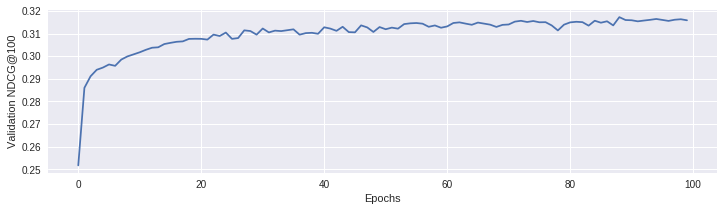

In [0]:
plt.figure(figsize=(12, 3))
plt.plot(ndcgs_vad)
plt.ylabel("Validation NDCG@100")
plt.xlabel("Epochs")
pass

* $\beta_{best}=0.4$

### Load the test data and compute test metrics

In [0]:
test_data_tr, test_data_te = load_tr_te_data(
    os.path.join(pro_dir, 'test_tr.csv'),
    os.path.join(pro_dir, 'test_te.csv'))

In [0]:
N_test = test_data_tr.shape[0]
idxlist_test = range(N_test)

batch_size_test = 2000

In [0]:
tf.reset_default_graph()
vae = MultiVAE(p_dims, lam=0.0)
saver, logits_var, _, _, _,_ = vae.build_graph()    

INFO:tensorflow:Scale of 0 disables regularizer.


Load the best performing model on the validation set

In [0]:
chkpt_dir = './chkpt/ml-20m/VAE_anneal{}K_cap{:1.1E}/{}'.format(
    total_anneal_steps/1000, anneal_cap, arch_str)
print("chkpt directory: %s" % chkpt_dir)

chkpt directory: ./chkpt/ml-20m/VAE_anneal20.0K_cap1.0E+00/I-600-200-2-200-600-I


In [0]:
n100_list, r20_list, r50_list = [], [], []

with tf.Session() as sess:
    saver.restore(sess, '{}/model'.format(chkpt_dir))

    for bnum, st_idx in enumerate(range(0, N_test, batch_size_test)):
        end_idx = min(st_idx + batch_size_test, N_test)
        X = test_data_tr[idxlist_test[st_idx:end_idx]]

        if sparse.isspmatrix(X):
            X = X.toarray()
        X = X.astype('float32')

        pred_val = sess.run(logits_var, feed_dict={vae.input_ph: X})
        # exclude examples from training and validation (if any)
        pred_val[X.nonzero()] = -np.inf
        n100_list.append(NDCG_binary_at_k_batch(pred_val, test_data_te[idxlist_test[st_idx:end_idx]], k=100))
        r20_list.append(Recall_at_k_batch(pred_val, test_data_te[idxlist_test[st_idx:end_idx]], k=20))
        r50_list.append(Recall_at_k_batch(pred_val, test_data_te[idxlist_test[st_idx:end_idx]], k=50))
    
n100_list = np.concatenate(n100_list)
r20_list = np.concatenate(r20_list)
r50_list = np.concatenate(r50_list)

INFO:tensorflow:Restoring parameters from ./chkpt/ml-20m/VAE_anneal20.0K_cap1.0E+00/I-600-200-2-200-600-I/model


In [0]:
print("Test NDCG@100=%.5f (%.5f)" % (np.mean(n100_list), np.std(n100_list) / np.sqrt(len(n100_list))))
print("Test Recall@20=%.5f (%.5f)" % (np.mean(r20_list), np.std(r20_list) / np.sqrt(len(r20_list))))
print("Test Recall@50=%.5f (%.5f)" % (np.mean(r50_list), np.std(r50_list) / np.sqrt(len(r50_list))))

Test NDCG@100=0.31556 (0.00203)
Test Recall@20=0.28435 (0.00263)
Test Recall@50=0.40660 (0.00297)


### Inference

In [0]:
!unzip Origin_VAE_100Epoch.zip 

Archive:  Origin_VAE_100Epoch.zip
  inflating: checkpoint              
  inflating: model.data-00000-of-00001  
  inflating: model.index             
  inflating: model.meta              


In [0]:
chkpt_dir = './chkpt/ml-20m/VAE_anneal{}K_cap{:1.1E}/{}'.format(
    total_anneal_steps/1000, anneal_cap, arch_str)
print("chkpt directory: %s" % chkpt_dir)

chkpt directory: ./chkpt/ml-20m/VAE_anneal20.0K_cap1.0E+00/I-600-200-2-200-600-I


In [0]:
p_dims = [200, 600, n_items]
tf.reset_default_graph()
vae = MultiVAE(p_dims, lam=0.0, random_seed=98765)

saver, logits_var, loss_var, train_op_var, merged_var, sampled_z = vae.build_graph()

INFO:tensorflow:Scale of 0 disables regularizer.


In [0]:
z=[]

with tf.Session() as sess:
    saver.restore(sess, './model')
    #saver.restore(sess, '{}/model'.format(chkpt_dir))
    
    for bnum, st_idx in enumerate(range(0, N, batch_size)):
        end_idx = min(st_idx + batch_size, N)
        X = train_data[idxlist[st_idx:end_idx]]
            
        if sparse.isspmatrix(X):
            X = X.toarray()
        X = X.astype('float32')           
        feed_dict = {vae.input_ph: X, }        
        train_z = sess.run(sampled_z, feed_dict={vae.input_ph: X})
        z.append(train_z)
z=pd.DataFrame(np.concatenate(z))

INFO:tensorflow:Restoring parameters from ./model


In [0]:
z.head()

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,0.159614,0.086682,0.052296,-0.038898,-0.031579,0.034758,0.060331,0.009717,-0.064580,0.017390,...,-0.437224,-0.060964,0.033848,-1.764111,0.079282,-0.026105,0.069869,-0.017732,-0.534219,0.021136
1,-0.069972,0.090979,0.043689,-0.005876,-0.034053,0.034708,-0.018599,-0.115400,0.067768,0.024590,...,0.430274,-0.020542,0.034036,-0.325822,0.009739,0.069527,0.005347,-0.068706,0.053821,-0.007959
2,0.116432,0.005869,-0.064019,0.017035,-0.033380,-0.037675,-0.007369,0.119163,-0.013019,-0.032070,...,0.040974,-0.145135,-0.025116,0.205805,-0.015766,0.084616,-0.054483,-0.020843,-0.297791,-0.030666
3,0.177680,0.106857,-0.051899,-0.124060,-0.053902,0.151813,0.028912,0.064882,0.094049,-0.137049,...,-0.567100,0.075318,0.089562,1.221815,-0.085125,0.051225,0.197643,0.029706,0.784211,-0.074551
4,0.024307,-0.023241,-0.017424,-0.063001,-0.020492,-0.002880,0.061781,0.135009,0.013104,0.045799,...,0.258387,-0.070428,0.059456,-0.319855,-0.078491,-0.018846,0.065372,0.037494,0.542865,-0.030697


#### Clustering Using Laten Z 200

In [0]:
from sklearn.cluster import KMeans

In [0]:
n=int(z.shape[0]*1)
samples=z.sample(n)
samples.shape

(116677, 200)

In [0]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(samples)
print(kmeans.inertia_)
kmeans.labels_


3637189.263125866


array([0, 0, 0, ..., 1, 0, 0], dtype=int32)

In [0]:
minRes=2**31

for i in range(11,20):
  kmeans = KMeans(n_clusters=i, random_state=1).fit(z)
  elbow.append(kmeans.inertia_)
  if kmeans.inertia_<minRes:
    minRes=kmeans.inertia_
    label=kmeans.labels_.copy()


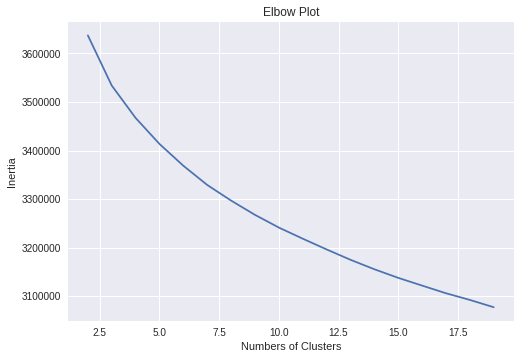

In [0]:
fig, ax = plt.subplots()
ax.plot(range(2,20),elbow)


ax.set(xlabel='Numbers of Clusters', ylabel='Inertia',
       title='Elbow Plot')

plt.show()

#### Check Normality of Z

Selected Laten Z:  1


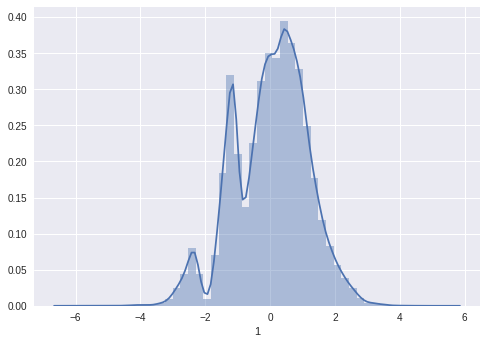

In [0]:
i=int(np.random.uniform(0,2,1)[0])
print('Selected Laten Z: ',i)
sns.distplot(z[i])
plt.show()

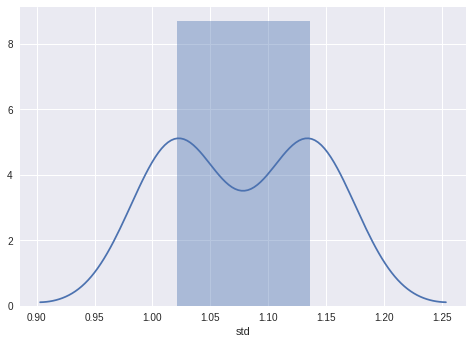

In [0]:
#Histogram for Std of laten variable
sns.distplot(z.describe().iloc[2,:])
plt.show()

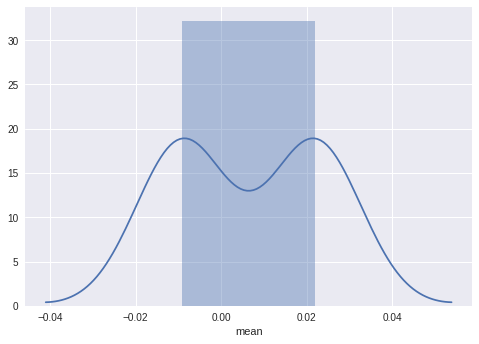

In [0]:
#Histogram for mean of laten variable
sns.distplot(z.describe().iloc[1,:])
plt.show()

In [0]:
from statsmodels.stats.diagnostic import kstest_normal

result=[]
for i in z.columns:
  k,p=kstest_normal(z[i])
  result.append(p<=0.5)

print('Number of laten variables passed KS Normal Test: ', np.sum(result))

Number of laten variables passed KS Normal Test:  2


/usr/local/lib/python3.6/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


* All laten variables are normally distributed, with mean approximate 0 and follow a normal distribution. 
* However, the standard error displays strange performance. Most of std of laten variable fall in the interval (0, 0.2], while by setting the prior of z to be standard normal distribution, std should approximate 1  

#### TSNE for 200 Laten Variables

In [0]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [0]:
n=int(z.shape[0]*0.02)
samples=z.sample(n)
samples.shape

(2333, 200)

In [0]:
z_embedded=TSNE(n_components=2,perplexity=30.0).fit_transform(samples*100)


In [0]:
z_embedded=pd.DataFrame(z_embedded)
z_embedded.head()

,0,1
0,15.003423,-7.851286
1,-20.129047,5.319506
2,-24.277945,-19.183674
3,4.073391,46.203255
4,-11.901103,16.813236


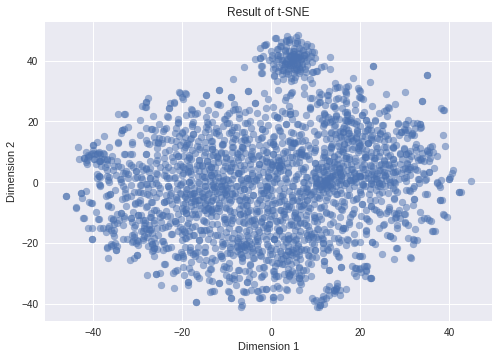

In [0]:

fig, ax = plt.subplots()
ax.scatter(z_embedded[0],z_embedded[1],alpha=0.5)


ax.set(xlabel='Dimension 1', ylabel='Dimension 2',
       title='Result of t-SNE')

plt.show()

#### PCA for 200 Laten Variables

In [0]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [0]:
n=int(z.shape[0]*1)
samples=z.sample(n)
samples.shape

(116677, 200)

In [0]:
samples=samples*100
samples.head()

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
31725,0.879529,-4.127810,-0.619228,-10.158484,3.064661,3.323671,1.782602,-0.499889,-6.406368,2.789973,...,-68.846558,-1.376836,1.016965,18.398087,-11.192636,8.324554,0.546225,-9.176378,-22.275475,2.140068
37946,27.199751,20.226942,8.336474,22.788424,5.889791,-13.388513,2.816837,-6.829818,14.430640,7.055934,...,-13.739692,-13.896569,-16.010431,217.413574,11.720551,1.983589,4.336163,5.457605,46.151943,5.736229
45853,6.925982,4.180706,-2.897846,3.649636,-2.482546,-1.087160,-2.614169,2.714233,6.625868,2.565583,...,-122.105095,-2.405867,-1.603479,73.833336,-6.400856,4.407083,4.336412,-6.784304,-14.693221,-5.505446
111566,6.666096,7.186054,-2.564251,0.890254,-10.001471,15.122980,-2.101808,-19.798082,9.922489,-9.424535,...,-83.874107,2.710533,-6.751575,-104.158638,-4.767247,-1.550230,8.441338,-7.422728,39.257862,-5.922480
73302,6.488579,16.162880,-16.119701,-14.464847,10.067333,-7.292429,6.978679,-41.180904,6.382266,-23.534016,...,-23.634846,-2.849344,-7.676138,55.784260,10.009171,3.920518,11.727046,-7.088821,25.732172,-12.849998


[0.04614776 0.03938222 0.03686069 0.03324032 0.0321448  0.03132747
 0.02856461 0.02727116 0.02580834 0.02463376 0.02381964 0.02268284
 0.02240976 0.02141618 0.02083806 0.01998063 0.01931918 0.01879965
 0.01844409 0.01785446 0.01701853 0.01669791 0.01622527 0.01574308
 0.01535214 0.01513593 0.01477032 0.0143681  0.01410612 0.01400389
 0.01342597 0.01281333 0.01256734 0.01229087 0.01215567 0.01185889
 0.01154838 0.01112321 0.01073042 0.01032797 0.00987142 0.00968206
 0.0094125  0.00931264 0.0089373  0.00870318 0.0085854  0.00844244
 0.008323   0.0080402 ]
total explained variance:  0.8925190975141243


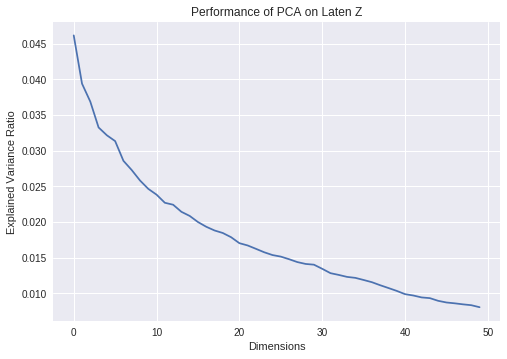

In [0]:
pca = PCA(n_components=50)
pca.fit(samples)
print(pca.explained_variance_ratio_) 
print('total explained variance: ', np.sum(pca.explained_variance_ratio_))

fig, ax = plt.subplots()
ax.plot(pca.explained_variance_ratio_)


ax.set(xlabel='Dimensions', ylabel='Explained Variance Ratio',
       title='Performance of PCA on Laten Z')
plt.show()

#### Plot for 2 Laten Z


In [0]:
n=int(z.shape[0]*0.02)
samples=z.sample(n)
samples.shape

(2333, 2)

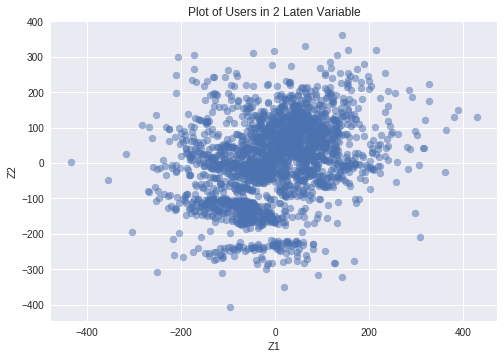

In [0]:
fig, ax = plt.subplots()
ax.scatter(samples[0]*100,samples[1]*100,alpha=0.5)

ax.set(xlabel='Z1', ylabel='Z2',title='Plot of Users in 2 Laten Variable')
plt.show()